<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/data_utils/data_preparation/listings_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install ast
import numpy as np
import ast
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import json
drive.mount('/content/drive')

# Data preparation translated_listings.pickle

In [ ]:
path= ("/content/drive/MyDrive/Colab/airbnb/data/translations/translated_listings.pickle")
listings = pd.read_pickle(path)

In [ ]:
# set id as row index and rename to listing_id
listings.set_index('id', inplace=True)
listings.index.name = "listing_id"

In [ ]:
# remove columns from listings that do not make sense as predictors

drop_vars = ["name", "listing_url", "scrape_id", "last_scraped", "picture_url", 
       "neighborhood_overview", "description", "host_id",
       "host_url", "host_name", "host_location", "host_about",
       "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_total_listings_count",
       "host_has_profile_pic", "neighbourhood", "neighbourhood_group_cleansed", "bathrooms",
       "maximum_nights", "maximum_nights",	"minimum_minimum_nights", 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',"has_availability", "calendar_last_scraped",
       "number_of_reviews_ltm", "number_of_reviews_l30d", "license"]

listings = listings.drop(drop_vars, axis=1)

In [ ]:
# transform price
listings["price"] = (
    listings["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

# save listing ids where price is zero in missing_data file
with open("/content/drive/MyDrive/Colab/airbnb/data/data1/missing_data.json", "r") as f:
    missing_data = json.load(f)

price_zero = listings[listings["price"] == 0].index
missing_data["price"] = list(price_zero)

with open("/content/drive/MyDrive/Colab/airbnb/data/data1/missing_data.json", "w") as f:
    json.dump(missing_data, f, indent=6)

#remove zeros from price
listings = listings[listings["price"] != 0]

# log price
listings["log_price"] = np.log(listings["price"])

# plot log price
# plt.hist(listings["log_price"], bins=50)
# plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# recode property into three categories
property_type_entire_unit = listings["property_type"].str.contains("Entire", case=False, na=False)
property_type_entire_unit = property_type_entire_unit.astype("int")
property_type_entire_unit.name = "property_type_entire_unit"
property_type_shared_room = listings["property_type"].str.contains("Shared", case=False, na=False)
property_type_shared_room = property_type_shared_room.astype("int")
property_type_shared_room.name = "property_type_shared_room"
property_type_private_room = listings["property_type"].str.contains("Private", case=False, na=False)
property_type_private_room = property_type_private_room.astype("int")
property_type_private_room.name = "property_type_private_room"
listings = listings.drop("property_type", axis=1)

In [ ]:
# recode rooms, neighbourhood_cleansed, properties, host_is_superhost, instant_bookable and host_identity_verified into dummies
rooms = pd.get_dummies(listings["room_type"], prefix="room")
listings = listings.drop("room_type", axis=1)

neighbourhood_cleansed = pd.get_dummies(listings["neighbourhood_cleansed"], prefix="neighbourhood_cleansed")
listings = listings.drop("neighbourhood_cleansed", axis=1)

listings["host_is_superhost"] = listings["host_is_superhost"].map(dict(t=1, f=0))
listings["instant_bookable"] = listings["instant_bookable"].map(dict(t=1, f=0))
listings["host_identity_verified"] = listings["host_identity_verified"].map(
    dict(t=1, f=0)
)

listings = pd.concat([listings, rooms, neighbourhood_cleansed, property_type_entire_unit, property_type_shared_room, property_type_private_room], axis=1)


In [ ]:
# recode host_verifications into dummies
listings["host_verifications"] = listings["host_verifications"].apply(ast.literal_eval)
host_verifications = listings["host_verifications"]
host_verifications = pd.get_dummies(host_verifications.apply(pd.Series).stack(dropna=False), prefix="host_verification").sum(level=0)
listings = pd.concat([listings, host_verifications], axis=1)
listings = listings.drop("host_verifications", axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  after removing the cwd from sys.path.


In [ ]:
# recode bath into bath shared dummy and number of baths
bath_is_shared = listings["bathrooms_text"].str.contains("shared", case=False, na=False)
bath_is_shared.name = "bath_is_shared"
bath_is_shared = bath_is_shared.astype("int")
bath_is_half = listings["bathrooms_text"].str.contains("half", case=False, na=False)
bath_number = listings["bathrooms_text"].str.extract('(\d+\.?\d?)', expand=False)
bath_number[bath_is_half] = 0.5
bath_number = bath_number.astype("float")
bath_number.name = "bath_number"

listings = pd.concat([listings, bath_is_shared, bath_number], axis=1)
listings = listings.drop("bathrooms_text", axis=1)

In [ ]:
#@title recode amenities functions
def contains_list(elements, series):
    df = (series == "Not existing value").astype("int")
    for el in elements:
        df = df + series.str.contains(el, case=False, na=0)
    return df
    
def to_binary(series):
  series = (series > 0).astype(int)
  return series

In [ ]:
# look at observation with specific amenity
listings["amenities"].loc[contains_list(["\"sauna"], listings["amenities"]).astype(bool)].iloc[0]

'["Wine glasses", "Lock on bedroom door", "Safe", "Iron", "Hair dryer", "First aid kit", "Bed linens", "Room-darkening shades", "Paid parking on premises", "TV", "Hangers", "Long term stays allowed", "Crib", "Dedicated workspace", "Host greets you", "Fire extinguisher", "Shower gel", "Carbon monoxide alarm", "Luggage dropoff allowed", "Paid parking off premises", "Smoke alarm", "Wifi", "Elevator", "Microwave", "Laundromat nearby", "Hot water", "Sauna", "Air conditioning", "Refrigerator", "Essentials", "Body soap", "Clothing storage", "Shampoo", "Heating", "Gym", "Dishes and silverware", "Free street parking"]'

In [ ]:
# print number of observations with specific amenity
np.sum(contains_list(["bathtub"], listings["amenities"]))

1491

In [ ]:
#@title recode amenities

# binaries1
tmp_amenities = ["Table corner guards"]
amenities_tablecornerguards = contains_list(tmp_amenities, listings["amenities"])
amenities_tablecornerguards.name = "amenities_" + "amenities_tablecornerguards"
amenities_tablecornerguards = to_binary(amenities_tablecornerguards)

tmp_amenities = ["Cleaning before checkout"]
amenities_cleanbeforecheckout = contains_list(tmp_amenities, listings["amenities"])
amenities_cleanbeforecheckout.name = "amenities_" + "amenities_cleanbeforecheckout"
amenities_cleanbeforecheckout = to_binary(amenities_cleanbeforecheckout)

tmp_amenities = ["Cleaning products"]
amenities_cleaningproducts = contains_list(tmp_amenities, listings["amenities"])
amenities_cleaningproducts.name = "amenities_" + "amenities_cleaningproducts"
amenities_cleaningproducts = to_binary(amenities_cleaningproducts)

tmp_amenities = ["host greets you"]
amenities_greetings = contains_list(tmp_amenities, listings["amenities"])
amenities_greetings.name = "amenities_" + "greetings"
amenities_greetings = to_binary(amenities_greetings)

tmp_amenities = ["building staff"]
amenities_staff = contains_list(tmp_amenities, listings["amenities"])
amenities_staff.name = "amenities_" + "staff"
amenities_staff = to_binary(amenities_staff)

tmp_amenities = ["elevator"]
amenities_elevator = contains_list(tmp_amenities, listings["amenities"])
amenities_elevator.name = "amenities_" + "elevator"
amenities_elevator = to_binary(amenities_elevator)

tmp_amenities = ["Single level home"]
amenities_singlelevel = contains_list(tmp_amenities, listings["amenities"])
amenities_singlelevel.name = "amenities_" + "singlelevel"
amenities_singlelevel = to_binary(amenities_singlelevel)

tmp_amenities = ["keypad"]
amenities_keypad = contains_list(tmp_amenities, listings["amenities"])
amenities_keypad.name = "amenities_" + "keypad"
amenities_keypad = to_binary(amenities_keypad)

tmp_amenities = ["private entrance"]
amenities_privateentrance = contains_list(tmp_amenities, listings["amenities"])
amenities_privateentrance.name = "amenities_" + "privateentrance"
amenities_privateentrance = to_binary(amenities_privateentrance)

tmp_amenities = ["bidet"]
amenities_bidet = contains_list(tmp_amenities, listings["amenities"])
amenities_bidet.name = "amenities_" + "bidet"
amenities_bidet = to_binary(amenities_bidet)

tmp_amenities = ["bathtub"]
amenities_bathtub = contains_list(tmp_amenities, listings["amenities"])
amenities_bathtub.name = "amenities_" + "bathtub"
amenities_bathtub = to_binary(amenities_bathtub)

tmp_amenities = ["fire extinguisher"]
amenities_extinguisher = contains_list(tmp_amenities, listings["amenities"])
amenities_extinguisher.name = "amenities_" + "extinguisher"
amenities_extinguisher = to_binary(amenities_extinguisher)

tmp_amenities = ["dining table"]
amenities_diningtable = contains_list(tmp_amenities, listings["amenities"])
amenities_diningtable.name = "amenities_" + "diningtable"
amenities_diningtable = to_binary(amenities_diningtable)

tmp_amenities = ["smart lock"]
amenities_smartlock = contains_list(tmp_amenities, listings["amenities"])
amenities_smartlock.name = "amenities_" + "smartlock"
amenities_smartlock = to_binary(amenities_smartlock)

tmp_amenities = ["Security cameras on property"]
amenities_cameras = contains_list(tmp_amenities, listings["amenities"])
amenities_cameras.name = "amenities_" + "cameras"
amenities_cameras = to_binary(amenities_cameras)

tmp_amenities = ["tv"]
amenities_tv = contains_list(tmp_amenities, listings["amenities"])
amenities_tv.name = "amenities_" + "tv"
amenities_tv = to_binary(amenities_tv)

tmp_amenities = ["sound system", "record player"]
amenities_sound_system = contains_list(tmp_amenities, listings["amenities"])
amenities_sound_system.name = "amenities_" + "soundsystem"
amenities_sound_system = to_binary(amenities_sound_system)

tmp_amenities = ["AC", "air conditioning"]
amenities_aircon = contains_list(tmp_amenities, listings["amenities"])
amenities_aircon.name = "amenities_" + "aircon"
amenities_aircon = to_binary(amenities_aircon)

tmp_amenities = ["lake", "Waterfront", "Boat slip", "beachfront"]
amenities_water_access = contains_list(tmp_amenities, listings["amenities"])
amenities_water_access.name = "amenities_" + "wateraccess"
amenities_water_access = to_binary(amenities_water_access)

tmp_amenities = ["safe", "lockbox"]
amenities_safe = contains_list(tmp_amenities, listings["amenities"])
amenities_safe.name = "amenities_" + "safe"
amenities_safe = to_binary(amenities_safe)

tmp_amenities = ["piano"]
amenities_piano = contains_list(tmp_amenities, listings["amenities"])
amenities_piano.name = "amenities_" + "piano"
amenities_piano = to_binary(amenities_piano)

tmp_amenities = ["fireplace", "fire pit"]
amenities_fireplace = contains_list(tmp_amenities, listings["amenities"])
amenities_fireplace.name = "amenities_" + "fireplace"
amenities_fireplace = to_binary(amenities_fireplace)

tmp_amenities = ["bio", "ecological", "natur", "fairtrade", "organic"]
amenities_bio = contains_list(tmp_amenities, listings["amenities"])
amenities_bio.name = "amenities_" + "bio"
amenities_bio = to_binary(amenities_bio)

tmp_amenities = ["wifi", "Ethernet connection"]
amenities_wifi = contains_list(tmp_amenities, listings["amenities"])
amenities_wifi.name = "amenities_" + "wifi"
amenities_wifi = to_binary(amenities_wifi)

tmp_amenities = ["balcony"]
amenities_balcony = contains_list(tmp_amenities, listings["amenities"])
amenities_balcony.name = "amenities_" + "balcony"
amenities_balcony = to_binary(amenities_balcony)

tmp_amenities = ["\"Outdoor"]
amenities_outdoor = contains_list(tmp_amenities, listings["amenities"])
amenities_outdoor.name = "amenities_" + "outdoor"
amenities_outdoor = to_binary(amenities_outdoor)

# not sure if this is smart
tmp_amenities = ["smoke_alarm", "monoxide alarm"]
amenities_smoke_alarm = contains_list(tmp_amenities, listings["amenities"])
amenities_smoke_alarm.name = "amenities_" + "smokealarm"
amenities_smoke_alarm = to_binary(amenities_smoke_alarm)

tmp_amenities = ["pets"]
amenities_pets = contains_list(tmp_amenities, listings["amenities"])
amenities_pets.name = "amenities_" + "pets"
amenities_pets = to_binary(amenities_pets)

tmp_amenities = ["iron"]
amenities_iron = contains_list(tmp_amenities, listings["amenities"])
amenities_iron.name = "amenities_" + "iron"
amenities_iron = to_binary(amenities_iron)

tmp_amenities = ["heating"]
amenities_heating = contains_list(tmp_amenities, listings["amenities"])
amenities_heating.name = "amenities_" + "heating"
amenities_heating = to_binary(amenities_heating)

tmp_amenities = ["ev charger"]
amenities_ev_charger = contains_list(tmp_amenities, listings["amenities"])
amenities_ev_charger.name = "amenities_" + "evcharger"
amenities_ev_charger = to_binary(amenities_ev_charger)

tmp_amenities = ["\"gym\"", "Gym in building", "Shared gym"]
amenities_gym = contains_list(tmp_amenities, listings["amenities"])
amenities_gym.name = "amenities_" + "gym"
amenities_gym = to_binary(amenities_gym)

tmp_amenities = ["Baby monitor", "baby safety gates", "baby bath", 
                 "Babysitter recommendations", "Changing table", 
                 "crib", "high chair", "Outlet covers"]
amenities_baby = contains_list(tmp_amenities, listings["amenities"])
amenities_baby.name = "amenities_" + "baby"
amenities_baby = to_binary(amenities_baby)

tmp_amenities = ["Beach essentials", "Barbecue utensils", "Bikes", "Board games", "toys", "game console",
                 "ping pong", "Pool table", "bbq grill"]
amenities_games = contains_list(tmp_amenities, listings["amenities"])
amenities_games.name = "amenities_" + "games"
amenities_games = to_binary(amenities_games)

# binaries2
tmp_amenities = ["\"washer"]
amenities_washer = contains_list(tmp_amenities, listings["amenities"])
amenities_washer.name = "amenities_" + "washer"
amenities_washer = to_binary(amenities_washer)

tmp_amenities = ["Free washer"]
amenities_freewasher = contains_list(tmp_amenities, listings["amenities"])
amenities_freewasher.name = "amenities_" + "freewasher"
amenities_freewasher = to_binary(amenities_freewasher)

tmp_amenities = ["Paid washer"]
amenities_paidwasher = contains_list(tmp_amenities, listings["amenities"])
amenities_paidwasher.name = "amenities_" + "paidwasher"
amenities_paidwasher = to_binary(amenities_paidwasher)

tmp_amenities = ["\"dryer"]
amenities_dryer = contains_list(tmp_amenities, listings["amenities"])
amenities_dryer.name = "amenities_" + "dryer"
amenities_dryer = to_binary(amenities_dryer)

tmp_amenities = ["Free dryer"]
amenities_freedryer = contains_list(tmp_amenities, listings["amenities"])
amenities_freedryer.name = "amenities_" + "freedryer"
amenities_freedryer = to_binary(amenities_freedryer)

tmp_amenities = ["Paid dryer"]
amenities_paiddryer = contains_list(tmp_amenities, listings["amenities"])
amenities_paiddryer.name = "amenities_" + "paiddryer"
amenities_paiddryer = to_binary(amenities_paiddryer)

tmp_amenities = ["Private fenced garden or backyard", "Private garden or backyard"]
amenities_privategarden = contains_list(tmp_amenities, listings["amenities"])
amenities_privategarden.name = "amenities_" + "privategarden"
amenities_privategarden = to_binary(amenities_privategarden)

tmp_amenities = ["Shared fenced garden or backyard", "Shared garden or backyard"]
amenities_sharedgarden = contains_list(tmp_amenities, listings["amenities"])
amenities_sharedgarden.name = "amenities_" + "sharedgarden"
amenities_sharedgarden = to_binary(amenities_sharedgarden)

tmp_amenities = ["free carport, free driveway, free parking, free residential"]
amenities_free_parking = contains_list(tmp_amenities, listings["amenities"])
amenities_free_parking.name = "amenities_" + "freeparking"
amenities_free_parking = to_binary(amenities_free_parking)

tmp_amenities = ["paid parking, paid street"]
amenities_paid_parking = contains_list(tmp_amenities, listings["amenities"])
amenities_paid_parking.name = "amenities_" + "paidparking"
amenities_paid_parking = to_binary(amenities_paid_parking)

tmp_amenities = ["\"hot tub", "\"sauna"]
amenities_spa = contains_list(tmp_amenities, listings["amenities"])
amenities_spa.name = "amenities_" + "spa"
amenities_spa = to_binary(amenities_spa)

tmp_amenities = ["shared hot tub", "shared sauna"]
amenities_sharedspa = contains_list(tmp_amenities, listings["amenities"])
amenities_sharedspa.name = "amenities_" + "sharedspa"
amenities_sharedspa = to_binary(amenities_sharedspa)

tmp_amenities = ["private hot tub", "private sauna"]
amenities_privatespa = contains_list(tmp_amenities, listings["amenities"])
amenities_privatespa.name = "amenities_" + "privatespa"
amenities_privatespa = to_binary(amenities_privatespa)

tmp_amenities = ["\"pool\"", "indoor heated pool"]
amenities_pool = contains_list(tmp_amenities, listings["amenities"])
amenities_pool.name = "amenities_" + "pool"
amenities_pool = to_binary(amenities_pool)

tmp_amenities = ["Shared outdoor infinity rooftop pool", "Shared outdoor pool",
                 "Shared outdoor rooftop pool", "Shared pool"]
amenities_sharedpool = contains_list(tmp_amenities, listings["amenities"])
amenities_sharedpool.name = "amenities_" + "sharedpool"
amenities_sharedpool = to_binary(amenities_sharedpool)

tmp_amenities = ["private pool"]
amenities_privatepool = contains_list(tmp_amenities, listings["amenities"])
amenities_privatepool.name = "amenities_" + "privatepool"
amenities_privatepool = to_binary(amenities_privatepool)

# non-binaries
bath_amenities = ["soap", "conditioner", "shampoo", "shower gel", "bathroom essentials"]
amenities_nbath = contains_list(bath_amenities, listings["amenities"])
amenities_nbath.name = "amenities_" + "nbath"

tv_extras_amenities = ["premium", "amazon", "apple tv", "netflix", "HBO"]
amenities_tv_extras = contains_list(tv_extras_amenities, listings["amenities"])
amenities_tv_extras.name = "amenities_" + "tv_extras"

tmp_amenities = ["workspace", "office chair", "monitor"]
amenities_workspace = contains_list(tmp_amenities, listings["amenities"])
amenities_workspace.name = "amenities_" + "workspace"

tmp_amenities = ["clothing storage", "walk-in closet", "dresser", "wardrobe", "closet"]
amenities_clothingstrg = contains_list(tmp_amenities, listings["amenities"])
amenities_clothingstrg.name = "amenities_" + "clothingstrg"

amenities_wifi_speed = listings["amenities"].str.extract("(\d+)[^\d]+Mbps")[0].fillna(16).astype(int)
amenities_wifi_speed.name = "amenities_wifi_speed"

# not so sure if this is so smart maybe big guys like fridge as binary dunno
kitchen_amenities = ["stove", "oven", "refrigerator|fridge", "toaster", "rice maker", "kitchen",
                     "Coffee maker|coffee machine|nespresso machine", "Bread maker", "baking sheet", 
                     "dishwasher", "freezer", "kettle", "cooking basics", "dinnerware", "Dishes and silverware", 
                     "trash compactor", "microwave"]
amenities_nkitchen = contains_list(kitchen_amenities, listings["amenities"])
amenities_nkitchen.name = "amenities_" + "nkitchen"

# add amenities to listings
amenity_categories = [amenities_tablecornerguards, amenities_cleanbeforecheckout, amenities_cleaningproducts, amenities_greetings, amenities_staff, amenities_elevator, amenities_singlelevel, amenities_keypad, amenities_privateentrance, amenities_bidet,
                      amenities_bathtub, amenities_extinguisher, amenities_diningtable, amenities_smartlock, amenities_cameras, amenities_tv, amenities_sound_system,
                      amenities_aircon, amenities_water_access, amenities_safe, amenities_piano, amenities_fireplace, amenities_bio, amenities_wifi, amenities_balcony,
                      amenities_outdoor, amenities_smoke_alarm, amenities_pets, amenities_iron, amenities_heating, amenities_ev_charger, amenities_gym, amenities_baby,
                      amenities_games, amenities_washer, amenities_freewasher, amenities_paidwasher, amenities_dryer, amenities_freedryer, amenities_paiddryer,
                      amenities_privategarden, amenities_sharedgarden, amenities_free_parking, amenities_paid_parking, amenities_spa, amenities_sharedspa, amenities_privatespa,
                      amenities_pool, amenities_sharedpool, amenities_privatepool, amenities_nbath, amenities_tv_extras, amenities_workspace, amenities_clothingstrg,
                      amenities_nkitchen, amenities_wifi_speed]

listings = pd.concat([listings, *amenity_categories], axis=1)
listings = listings.drop("amenities", axis=1)

In [ ]:
# remove text garbage	
listings["description_en"] = listings["description_en"].str.replace("<.*?>", "")
listings["name_en"] = listings["name_en"].str.replace("<.*?>", "")
listings["host_about_en"] = listings["host_about_en"].str.replace("<.*?>", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
# append reviews to listings and remove zero price observations
reviews = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/data1/reviews_workfile.pickle")
listings = pd.concat([listings, reviews.rename("reviews")], axis=1)
listings = listings.loc[listings.index.difference(price_zero)]

In [ ]:
# missing observations
for j, i in enumerate(np.sum(listings.isna())):
    if not i == 0:
        print(np.sum(listings.isna()).index[j], i)

host_since 22
host_response_time 4752
host_response_rate 4752
host_acceptance_rate 4541
host_is_superhost 22
host_listings_count 22
host_identity_verified 22
bedrooms 1353
beds 439
first_review 2328
last_review 2328
review_scores_rating 2327
review_scores_accuracy 2437
review_scores_cleanliness 2437
review_scores_checkin 2438
review_scores_communication 2436
review_scores_location 2438
review_scores_value 2439
reviews_per_month 2328
bath_number 8
reviews 2328


In [ ]:
# this is necessary for some of the following transformations or to look up something on the web
listings_original = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/translations/translated_listings.pickle")
listings_original.set_index("id", inplace=True)

listings_original["price"] = (
    listings_original["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

listings_original = listings_original[listings_original["price"] != 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [ ]:
# remove host_response_time, acceptance rate and response rate # remove first_review, host_since and last_review
listings.drop(["host_response_time", "host_response_rate", "host_acceptance_rate", "first_review", "last_review", "host_since"], axis=1, inplace=True)

In [ ]:
# replace nan in review with ["no review"]
listings["reviews"] = listings["reviews"].apply(lambda x: x if isinstance(x, list) else ["no review"])

In [ ]:
# recode host_listings_count na values to actual number of listings in dataset

# 1. get host_ids where we have missing host_listings_count
host_id_missing_listings_count = listings_original.loc[listings_original["host_listings_count"].isna(), "host_id"]
host_id_missing_listings_count = host_id_missing_listings_count.reindex(host_id_missing_listings_count)
host_id_missing_listings_count = host_id_missing_listings_count.index
host_id_missing_listings_count =  listings_original.loc[listings_original["host_id"].isin(host_id_missing_listings_count)]["host_id"]
host_id_missing_listings_count = host_id_missing_listings_count.reset_index()
host_id_missing_listings_count = host_id_missing_listings_count.set_index("host_id")
host_id_missing_listings_count

# 2. concatenate (1) with the listings_count_calculated
listings_count_calculated = listings_original.groupby("host_id").size()
listings_count_calculated = listings_count_calculated[host_id_missing_listings_count.index]
listings_count_calculated.name = "listings_count_calculated"
listings_count_calculated = pd.concat([listings_count_calculated, host_id_missing_listings_count], axis=1)
listings_count_calculated = listings_count_calculated.set_index("id")
listings_count_calculated = listings_count_calculated["listings_count_calculated"]

# 3. replace nas with listings_count_calculated values
listings.loc[:, "host_listings_count"] = listings.loc[:, "host_listings_count"].fillna(listings_count_calculated)

In [ ]:
# recode nas in all review_scores aggregates to mean values
listings.loc[:, "review_scores_rating"] = listings.loc[:, "review_scores_rating"].fillna(listings["review_scores_rating"].mean())
listings.loc[:, "review_scores_accuracy"] = listings.loc[:, "review_scores_accuracy"].fillna(listings["review_scores_accuracy"].mean())
listings.loc[:, "review_scores_cleanliness"] = listings.loc[:, "review_scores_cleanliness"].fillna(listings["review_scores_cleanliness"].mean())
listings.loc[:, "review_scores_communication"] = listings.loc[:, "review_scores_communication"].fillna(listings["review_scores_communication"].mean())
listings.loc[:, "review_scores_checkin"] = listings.loc[:, "review_scores_checkin"].fillna(listings["review_scores_checkin"].mean())
listings.loc[:, "review_scores_location"] = listings.loc[:, "review_scores_location"].fillna(listings["review_scores_location"].mean())
listings.loc[:, "review_scores_value"] = listings.loc[:, "review_scores_value"].fillna(listings["review_scores_value"].mean())

In [ ]:
# recode reviews_per_month nas to 0
listings.loc[:, "reviews_per_month"] = listings.loc[:, "reviews_per_month"].fillna(0)

In [ ]:
# recode host_is_superhost na's according to superhost status at website (looked up manually)
listings.loc[pd.Index([21632198]), "host_is_superhost"] = 1
listings.loc[listings.host_is_superhost.isna(), "host_is_superhost"] = 0

In [ ]:
# replace bath_number nas to 0
listings.loc[:, "bath_number"] = listings.loc[:, "bath_number"].fillna(0)

In [ ]:
# recode bedrooms nas to 1
listings.loc[:, "bedrooms"] = listings.loc[:, "bedrooms"].fillna(1)

In [ ]:
# recodes beds nas to 1
listings.loc[:, "beds"] = listings.loc[:, "beds"].fillna(1)

In [ ]:
# recode host_identity_verified as looked up manually on the web
index_not_verified = pd.Index([2808957, 7079941, 8808555, 13880640])
listings.loc[index_not_verified, "host_identity_verified"] = listings.loc[index_not_verified, "host_identity_verified"].fillna(0)
listings.loc[:, "host_identity_verified"] = listings.loc[:, "host_identity_verified"].fillna(1)

# Incorporate variable from calendar

In [ ]:
path = "/content/drive/MyDrive/Colab/airbnb/data/data1/calendar.csv.gz"
calendar = pd.read_csv(path)

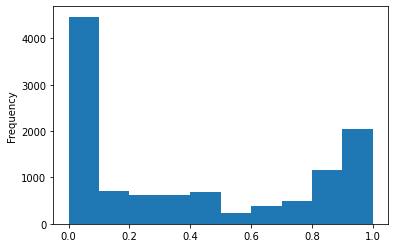

In [ ]:
calendar["available"] = calendar["available"].map(dict(t=1, f=0))
calendar.groupby("listing_id").available.mean().plot.hist()

In [ ]:
percent_available_nextyear = calendar.groupby("listing_id").available.mean()

In [ ]:
with open("/content/drive/MyDrive/Colab/airbnb/data/data1/missing_data.json", "r") as f:
    missing_data = json.load(f)

missing_price_index = percent_available_nextyear.index.isin(missing_data["price"])

In [ ]:
# add percent available next year to listings
percent_available_nextyear = percent_available_nextyear.loc[~missing_price_index]
percent_available_nextyear.name = "percent_available_nextyear"
listings = pd.concat([listings, percent_available_nextyear], axis=1)

# save transformed listings

In [ ]:
path = ("/content/drive/MyDrive/Colab/airbnb/data/data1/listings_workfile.pickle")
listings.to_pickle(path)

# scrap

In [ ]:
scrap_listings = pd.read_pickle("/content/drive/MyDrive/Colab/airbnb/data/translations/translated_listings.pickle")
scrap_listings.set_index("id", inplace=True)